# Austin Animal Center Outcome Prediction
## CS 363M Machine Learning Project - Riya Mittal

This notebook implements a machine learning solution to predict animal outcomes at the Austin Animal Center.

1. Data Loading and Exploration
2. Data Preprocessing
   - Handling Missing Values
   - Feature Engineering
   - Encoding Categorical Variables
3. Model Development
   - Base Model
   - Model Optimization
   - Model Evaluation
4. Final Predictions and Submission

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

## 1. Data Loading and Exploration
First, I'll load the data and perform initial exploratory data analysis to understand our dataset better.

In [6]:
# Load the training data
train_data = pd.read_csv('train.csv')

# Display basic information about the dataset
print("Dataset Shape:", train_data.shape)
print("\nDataset Info:")
train_data.info()

# Display first few rows
print("\nFirst few rows:")
train_data.head()

Dataset Shape: (111157, 14)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111157 entries, 0 to 111156
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Id                111157 non-null  object
 1   Name              79774 non-null   object
 2   Intake Time       111157 non-null  object
 3   Found Location    111157 non-null  object
 4   Intake Type       111157 non-null  object
 5   Intake Condition  111157 non-null  object
 6   Animal Type       111157 non-null  object
 7   Sex upon Intake   111155 non-null  object
 8   Age upon Intake   111156 non-null  object
 9   Breed             111157 non-null  object
 10  Color             111157 non-null  object
 11  Outcome Time      111157 non-null  object
 12  Date of Birth     111157 non-null  object
 13  Outcome Type      111157 non-null  object
dtypes: object(14)
memory usage: 11.9+ MB

First few rows:


,Id,Name,Intake Time,Found Location,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,Color,Outcome Time,Date of Birth,Outcome Type
0,A706918,Belle,07/05/2015 12:59:00 PM,9409 Bluegrass Dr in Austin (TX),Stray,Normal,Dog,Spayed Female,8 years,English Springer Spaniel,White/Liver,07/05/2015 03:13:00 PM,07/05/2007,Return to Owner
1,A724273,Runster,04/14/2016 06:43:00 PM,2818 Palomino Trail in Austin (TX),Stray,Normal,Dog,Intact Male,11 months,Basenji Mix,Sable/White,04/21/2016 05:17:00 PM,04/17/2015,Return to Owner
2,A857105,Johnny Ringo,05/12/2022 12:23:00 AM,4404 Sarasota Drive in Austin (TX),Public Assist,Normal,Cat,Neutered Male,2 years,Domestic Shorthair,Orange Tabby,05/12/2022 02:35:00 PM,05/12/2020,Transfer
3,A743852,Odin,02/18/2017 12:46:00 PM,Austin (TX),Owner Surrender,Normal,Dog,Neutered Male,2 years,Labrador Retriever Mix,Chocolate,02/21/2017 05:44:00 PM,02/18/2015,Return to Owner
4,A635072,Beowulf,04/16/2019 09:53:00 AM,415 East Mary Street in Austin (TX),Public Assist,Normal,Dog,Neutered Male,6 years,Great Dane Mix,Black,04/18/2019 01:45:00 PM,06/03/2012,Return to Owner


## Next Steps:
1. Load the actual data and analyze its characteristics
2. Implement data preprocessing steps
3. Create feature engineering pipeline
4. Implement XGBoost model with proper cross-validation
5. Optimize model performance
6. Generate predictions for submission

Note: This notebook will be expanded as we progress through each step of the modeling process.

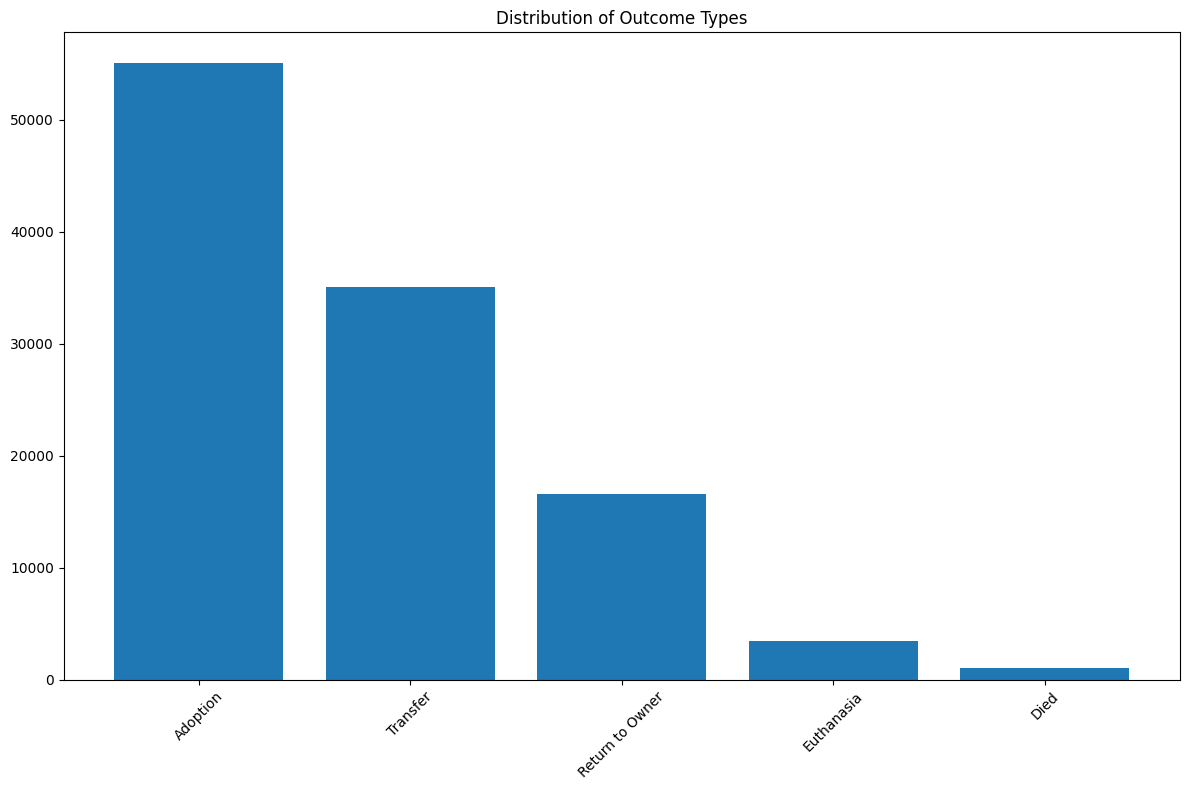

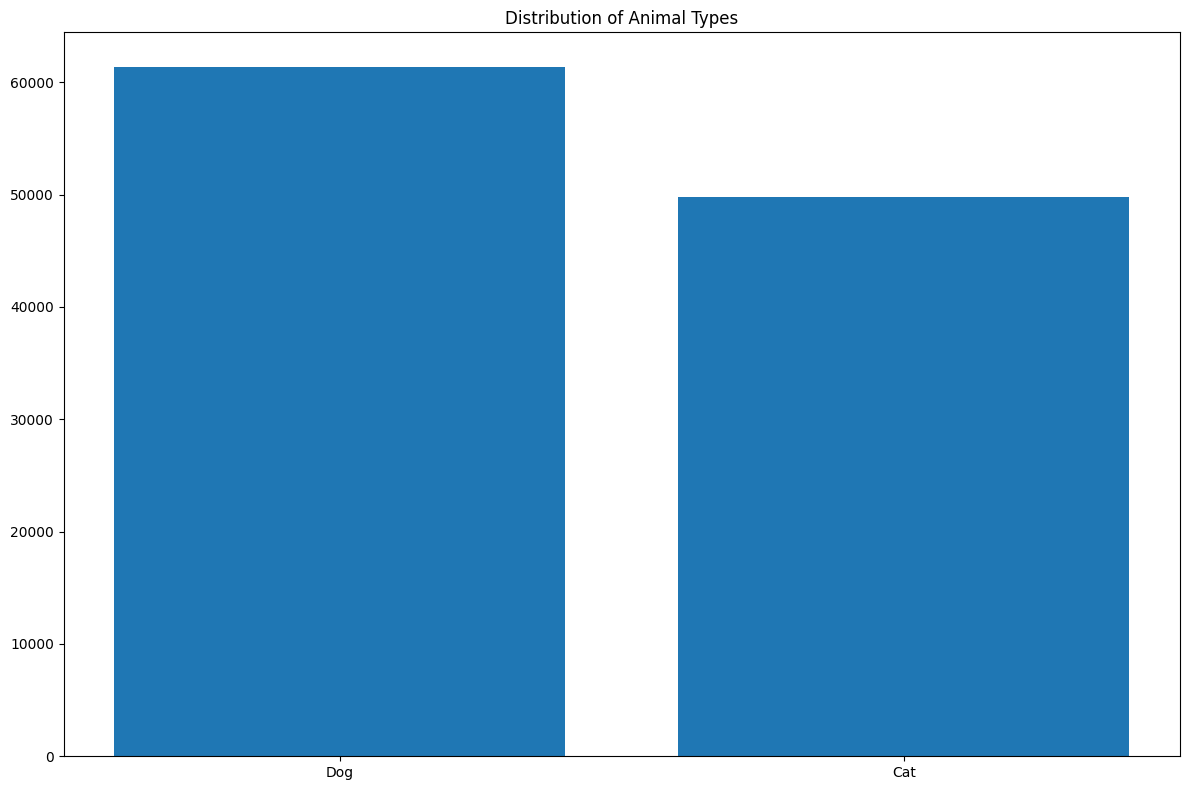


Missing Values Analysis:
Name               31383
Sex upon Intake        2
Age upon Intake        1
dtype: int64


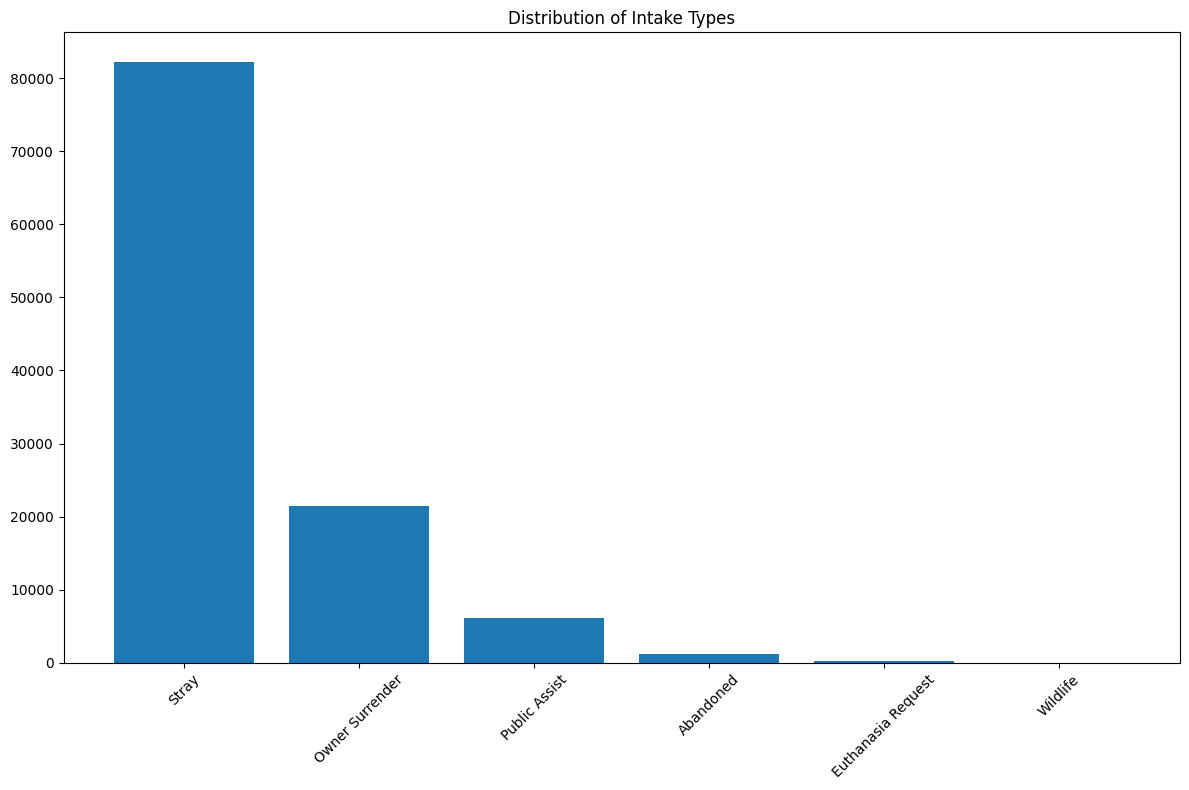

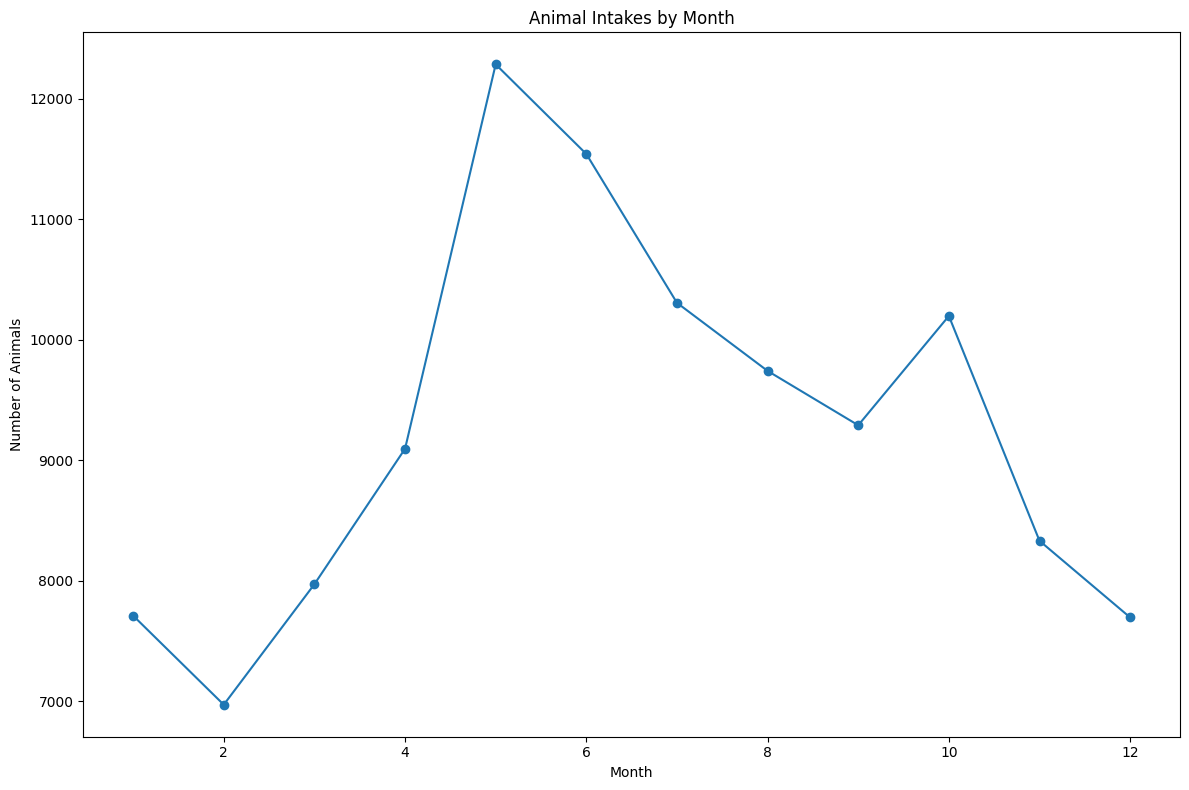


Key Statistics:

Total number of records: 111157

Outcome Type Distribution (%):
Outcome Type
Adoption           49.5
Transfer           31.5
Return to Owner    14.9
Euthanasia          3.1
Died                0.9
Name: proportion, dtype: float64

Animal Type Distribution (%):
Animal Type
Dog    55.2
Cat    44.8
Name: proportion, dtype: float64

Unique values in important categories:

Sex upon Intake: ['Spayed Female' 'Intact Male' 'Neutered Male' 'Intact Female' 'Unknown'
 nan]

Intake Type: ['Stray' 'Public Assist' 'Owner Surrender' 'Abandoned'
 'Euthanasia Request' 'Wildlife']

Intake Condition: ['Normal' 'Injured' 'Pregnant' 'Neonatal' 'Sick' 'Nursing' 'Aged'
 'Unknown' 'Med Attn' 'Medical' 'Other' 'Feral' 'Behavior' 'Med Urgent'
 'Space' 'Agonal' 'Parvo' 'Neurologic' 'Congenital']


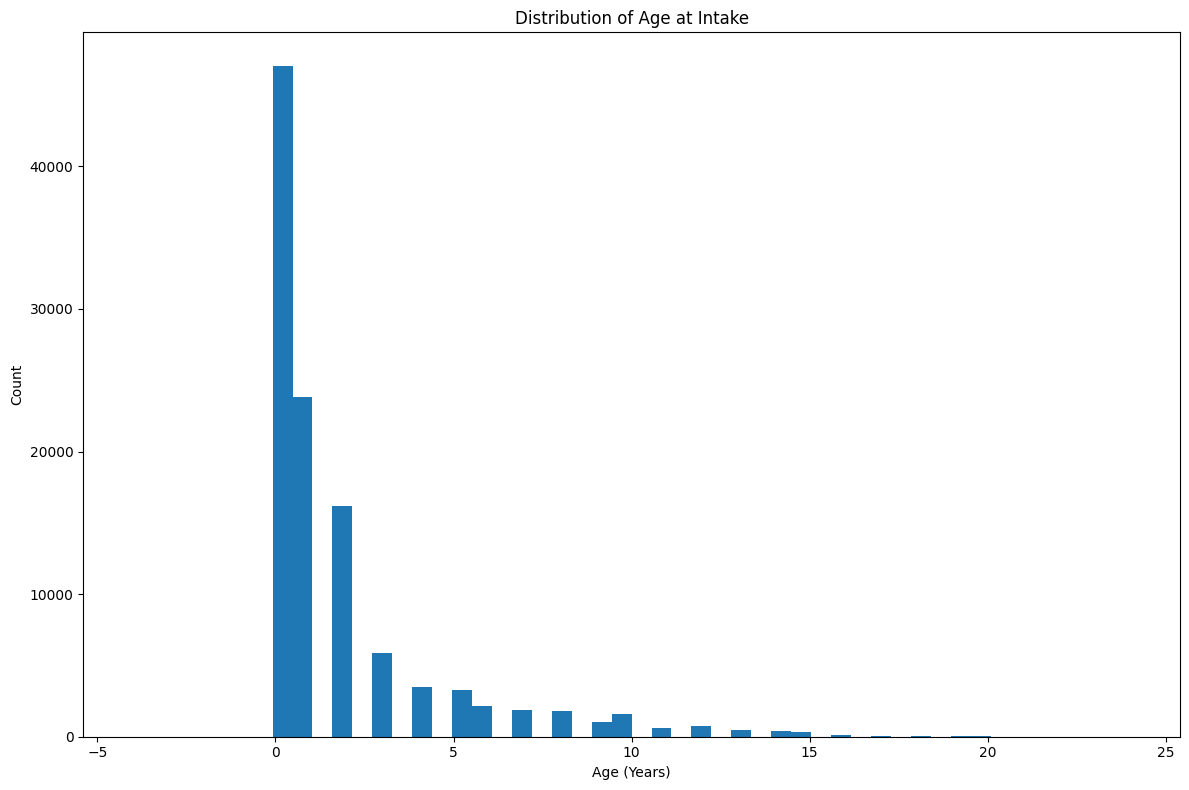


Most Common Breeds (top 5):
Breed
Domestic Shorthair Mix     25361
Domestic Shorthair         16046
Pit Bull Mix                6042
Labrador Retriever Mix      5654
Chihuahua Shorthair Mix     4896
Name: count, dtype: int64

Most Common Colors (top 5):
Color
Black/White          11620
Black                 9674
Brown Tabby           7708
White                 3945
Brown Tabby/White     3862
Name: count, dtype: int64


In [8]:
# Exploratory Data Analysis
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size for better visibility
plt.rcParams['figure.figsize'] = [12, 8]

# 1. Analyze target variable distribution
plt.figure(1)
outcome_counts = train_data['Outcome Type'].value_counts()
plt.bar(outcome_counts.index, outcome_counts.values)
plt.title('Distribution of Outcome Types')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Analyze animal types and their outcomes
plt.figure(2)
animal_counts = train_data['Animal Type'].value_counts()
plt.bar(animal_counts.index, animal_counts.values)
plt.title('Distribution of Animal Types')
plt.tight_layout()
plt.show()

# 3. Analyze missing values
print("\nMissing Values Analysis:")
missing_values = train_data.isnull().sum()
print(missing_values[missing_values > 0])

# 4. Analyze intake types
plt.figure(3)
intake_counts = train_data['Intake Type'].value_counts()
plt.bar(intake_counts.index, intake_counts.values)
plt.title('Distribution of Intake Types')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5. Analyze temporal patterns
train_data['Intake Time'] = pd.to_datetime(train_data['Intake Time'])
train_data['Intake Month'] = train_data['Intake Time'].dt.month

plt.figure(4)
monthly_counts = train_data['Intake Month'].value_counts().sort_index()
plt.plot(monthly_counts.index, monthly_counts.values, marker='o')
plt.title('Animal Intakes by Month')
plt.xlabel('Month')
plt.ylabel('Number of Animals')
plt.tight_layout()
plt.show()

# 6. Print summary statistics
print("\nKey Statistics:")
print("\nTotal number of records:", len(train_data))
print("\nOutcome Type Distribution (%):")
print(train_data['Outcome Type'].value_counts(normalize=True).round(3) * 100)
print("\nAnimal Type Distribution (%):")
print(train_data['Animal Type'].value_counts(normalize=True).round(3) * 100)

# 7. Analyze categorical variables
print("\nUnique values in important categories:")
print("\nSex upon Intake:", train_data['Sex upon Intake'].unique())
print("\nIntake Type:", train_data['Intake Type'].unique())
print("\nIntake Condition:", train_data['Intake Condition'].unique())

# 8. Age analysis
def extract_age_in_years(age_str):
    if pd.isna(age_str):
        return None
    parts = age_str.lower().split()
    value = float(parts[0])
    unit = parts[1]
    if 'year' in unit:
        return value
    elif 'month' in unit:
        return value/12
    elif 'week' in unit:
        return value/52
    elif 'day' in unit:
        return value/365
    return None

train_data['Age_Years'] = train_data['Age upon Intake'].apply(extract_age_in_years)
plt.figure(5)
plt.hist(train_data['Age_Years'], bins=50)
plt.title('Distribution of Age at Intake')
plt.xlabel('Age (Years)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 9. Print top breeds and colors
print("\nMost Common Breeds (top 5):")
print(train_data['Breed'].value_counts().head())
print("\nMost Common Colors (top 5):")
print(train_data['Color'].value_counts().head())

## 2. Data Preprocessing and Cleaning

Based on our exploratory data analysis, we need to clean and preprocess our data in several ways. Our cleaning strategy addresses the following key aspects:

### 2.1 Handling Missing Values
- **Name** (31,383 missing): Create a binary feature 'Had_Name' to capture whether the animal had a name, as this might indicate if it was a stray
- **Sex upon Intake** (2 missing): Fill with mode (most common value) as it's a very small number of missing values
- **Age upon Intake** (1 missing): Fill with mode for that specific animal type to maintain distribution

### 2.2 Standardizing Dates and Creating Time Features
- Convert all date/time columns to datetime format
- Create new features:
  - Days in shelter (difference between outcome and intake time)
  - Age at intake (in years)
  - Intake month (to capture seasonality)
  - Day of week (to capture weekly patterns)
  - Hour of day (to capture daily patterns)

### 2.3 Standardizing Age Data
- Convert various age formats (years, months, weeks, days) to a standard years format
- Create meaningful age groups:
  - Baby (< 6 months)
  - Young (6 months - 2 years)
  - Adult (2-5 years)
  - Senior (5-10 years)
  - Geriatric (> 10 years)

### 2.4 Cleaning Categorical Variables
- **Sex upon Intake**: Split into two features
  - Sex (Male/Female)
  - Fertility Status (Intact/Spayed/Neutered)
- **Location**: 
  - Remove redundant "in Austin (TX)" text
  - Create binary feature for known specific location
- **Breed**:
  - Create binary feature for mixed breeds
  - Extract primary breed
- **Color**:
  - Count number of colors
  - Extract primary color
- **Intake Condition**: Group into broader categories
  - Medical (Injured, Sick, Medical, etc.)
  - Behavioral (Feral, Behavior)
  - Normal

The cleaning process maintains the integrity of the original data while creating more structured and informative features for our model.

In [23]:
def clean_data(df):
    """
    Clean the dataset by:
    1. Handling missing values
    2. Converting data types
    3. Standardizing text formats
    4. Removing redundant information
    """
    df = df.copy()
    
    # 1. Handle missing values
    df['Name'] = df['Name'].fillna('Unknown')
    df['Sex upon Intake'] = df['Sex upon Intake'].fillna(df['Sex upon Intake'].mode()[0])
    df['Age upon Intake'] = df.groupby('Animal Type')['Age upon Intake'].transform(
        lambda x: x.fillna(x.mode()[0])
    )
    
    # 2. Convert date columns to datetime
    date_columns = ['Intake Time', 'Outcome Time', 'Date of Birth']
    for col in date_columns:
        df[col] = pd.to_datetime(df[col])
    
    # 3. Clean text fields
    # Remove redundant location text (case insensitive)
    df['Found Location'] = df['Found Location'].str.replace(' in Austin \([Tt][Xx]\)', '', regex=True)
    df['Found Location'] = df['Found Location'].str.replace('Austin \([Tt][Xx]\)', 'Unknown', regex=True)
    
    # Strip whitespace from text fields
    text_columns = ['Name', 'Found Location', 'Intake Type', 'Intake Condition', 
                   'Animal Type', 'Sex upon Intake', 'Breed', 'Color']
    for col in text_columns:
        df[col] = df[col].str.strip()
    
    # Standardize case (convert to title case)
    for col in text_columns:
        df[col] = df[col].str.title()
    
    # 4. Convert categorical columns to category dtype
    categorical_columns = ['Animal Type', 'Intake Type', 'Intake Condition', 
                         'Sex upon Intake', 'Outcome Type']
    for col in categorical_columns:
        df[col] = df[col].astype('category')
    
    # 5. Keep only original columns (no derived features)
    original_columns = [
        'Id', 'Name', 'Intake Time', 'Found Location', 'Intake Type',
        'Intake Condition', 'Animal Type', 'Sex upon Intake', 'Age upon Intake',
        'Breed', 'Color', 'Outcome Time', 'Date of Birth', 'Outcome Type'
    ]
    df = df[original_columns]
    
    return df

# Apply cleaning
cleaned_data = clean_data(train_data)

# Display results
print("Cleaned Data Info:")
cleaned_data.info()

# Check for any remaining missing values
print("\nMissing Values After Cleaning:")
print(cleaned_data.isnull().sum())

# Display sample of cleaned data
print("\nSample of Cleaned Data:")
print(cleaned_data.head())

/var/folders/b8/l43ql6p55y90lmpz76m3ftxc0000gn/T/ipykernel_3944/4218292765.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])


Cleaned Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111157 entries, 0 to 111156
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Id                111157 non-null  object        
 1   Name              111157 non-null  object        
 2   Intake Time       111157 non-null  datetime64[ns]
 3   Found Location    111157 non-null  object        
 4   Intake Type       111157 non-null  category      
 5   Intake Condition  111157 non-null  category      
 6   Animal Type       111157 non-null  category      
 7   Sex upon Intake   111157 non-null  category      
 8   Age upon Intake   111157 non-null  object        
 9   Breed             111157 non-null  object        
 10  Color             111157 non-null  object        
 11  Outcome Time      111157 non-null  datetime64[ns]
 12  Date of Birth     111157 non-null  datetime64[ns]
 13  Outcome Type      111157 non-null  categ

## 3. Feature Engineering

Based on our exploratory data analysis and domain knowledge of animal shelters, we'll create several types of features that could help predict animal outcomes:

### 3.1 Temporal Features
- **Age-Related**: Convert text age ("8 years", "11 months") to numeric values in years
- **Age Groups**: Create meaningful age categories (Baby, Young, Adult, Senior, Geriatric)
- **Length of Stay**: Calculate days between intake and outcome
- **Seasonal Patterns**: Extract month, day of week, and hour from intake time
- **Time Period**: Create features for morning/afternoon/evening intake

### 3.2 Animal Characteristics
- **Size and Breed**:
  - Create breed categories (e.g., Sporting, Working, Terrier for dogs)
  - Identify size categories based on breed (Small, Medium, Large)
  - Create binary indicator for mixed breeds
- **Color and Pattern**:
  - Separate base colors from patterns (e.g., "Orange Tabby" → "Orange" + "Tabby")
  - Count number of colors per animal
  - Group similar colors into categories

### 3.3 Intake Characteristics
- **Name Status**: Binary indicator if animal had a name (suggesting previous ownership)
- **Location Features**:
  - Create indicators for facility findings (shelters, clinics)
  - Identify residential area findings
- **Medical Status**:
  - Group intake conditions into broader categories (Normal, Medical, Behavioral)
  - Create urgency indicators based on condition
- **Sex and Fertility**: Separate sex (Male/Female) from fertility status (Intact/Spayed/Neutered)

### 3.4 Feature Selection and Dimensionality Reduction
- Remove highly correlated features
- Drop features with low variance
- Group rare categories in categorical variables
- Use domain knowledge to select most relevant features

### Justification for Feature Engineering Choices:
1. **Temporal Features**: Animals' outcomes often depend on their age and length of stay
2. **Breed/Size Features**: Different breeds and sizes have different adoption rates
3. **Color Features**: Certain colors/patterns may be more desirable for adoption
4. **Intake Features**: The circumstances of intake often indicate likelihood of different outcomes
5. **Medical Status**: Health and behavioral issues significantly impact outcomes

Each feature is designed to capture information that could influence an animal's outcome based on shelter dynamics and adoption patterns.

In [29]:
import pandas as pd
import numpy as np

def convert_age_to_years(age_str):
    """Convert age string to numeric years."""
    parts = age_str.lower().split()
    value = float(parts[0])
    unit = parts[1]
    
    if 'year' in unit:
        return value
    elif 'month' in unit:
        return value/12
    elif 'week' in unit:
        return value/52
    elif 'day' in unit:
        return value/365
    return None

def get_breed_group(breed, animal_type):
    """Determine breed group based on breed and animal type."""
    dog_groups = {
        'Sporting': ['Retriever', 'Spaniel', 'Pointer', 'Setter'],
        'Working': ['Shepherd', 'Rottweiler', 'Great Dane', 'Husky', 'Mastiff'],
        'Terrier': ['Terrier', 'Pit Bull'],
        'Toy': ['Chihuahua', 'Poodle', 'Yorkshire', 'Maltese', 'Shih Tzu'],
        'Hound': ['Hound', 'Beagle', 'Dachshund', 'Basenji'],
        'Non-Sporting': ['Bulldog', 'Chow Chow', 'Dalmatian']
    }
    
    if animal_type == 'Cat':
        return 'Cat'
    if pd.isna(breed):
        return 'Unknown'
    for group, breeds in dog_groups.items():
        if any(b.lower() in breed.lower() for b in breeds):
            return group
    return 'Other Dog'

def extract_color_pattern(color):
    """Extract base color and pattern from color string."""
    patterns = ['Tabby', 'Brindle', 'Tortie', 'Torbie', 'Pointed', 'Merle', 'Tuxedo']
    
    if pd.isna(color):
        return 'Unknown', 'Unknown'
    pattern = next((p for p in patterns if p.lower() in color.lower()), 'Solid')
    base_color = color.split('/')[0].strip()
    return base_color, pattern

def engineer_features(df):
    """
    Create engineered features from cleaned data for animal shelter outcome prediction.
    """
    df = df.copy()
    
    # Store target variable
    y = df['Outcome Type']
    
    ###################
    # 1. Core Features
    ###################
    
    core_features = pd.DataFrame({
        'id': df['Id'],
        'age_years': df['Age upon Intake'].apply(convert_age_to_years),
        'days_in_shelter': (df['Outcome Time'] - df['Intake Time']).dt.total_seconds() / (24*60*60),
        'color_count': df['Color'].str.count('/') + 1
    })
    
    ###################
    # 2. Temporal Features
    ###################
    
    temporal_features = pd.DataFrame({
        'intake_month': df['Intake Time'].dt.month,
        'intake_day': df['Intake Time'].dt.dayofweek,
        'intake_hour': df['Intake Time'].dt.hour,
        'intake_year': df['Intake Time'].dt.year - 2015,
        'is_weekend': df['Intake Time'].dt.dayofweek.isin([5, 6]).astype(int),
        'is_birth_season': df['Intake Time'].dt.month.isin([3, 4, 5, 6]).astype(int)
    })
    
    ###################
    # 3. Animal Features
    ###################
    
    animal_features = pd.DataFrame({
        'is_dog': (df['Animal Type'] == 'Dog').astype(int),
        'is_cat': (df['Animal Type'] == 'Cat').astype(int),
        'is_mix': df['Breed'].str.contains('Mix', case=False).astype(int),
        'is_black': df['Color'].str.contains('Black', case=False).astype(int),
        'is_prime_age': (
            ((df['Animal Type'] == 'Dog') & (core_features['age_years'] <= 3)) |
            ((df['Animal Type'] == 'Cat') & (core_features['age_years'] <= 3))
        ).astype(int)
    })
    
    ###################
    # 4. Intake Features
    ###################
    
    intake_features = pd.DataFrame({
        'has_name': (~df['Name'].isin(['Unknown', 'Unnamed'])).astype(int),
        'found_at_facility': df['Found Location'].str.contains(
            'shelter|clinic|hospital|vet', 
            case=False, 
            regex=True
        ).astype(int),
        'found_in_residential': df['Found Location'].str.contains(
            'street|road|lane|drive|circle|avenue|court|way', 
            case=False, 
            regex=True
        ).astype(int),
        'is_male': df['Sex upon Intake'].str.contains('Male', case=False).astype(int),
        'is_intact': df['Sex upon Intake'].str.contains('Intact', case=False).astype(int)
    })
    
    # Add medical/behavioral status
    medical_conditions = ['Injured', 'Sick', 'Medical', 'Med Attn', 'Med Urgent', 
                         'Nursing', 'Pregnant', 'Neonatal', 'Aged', 'Parvo', 'Neurologic']
    behavioral_conditions = ['Feral', 'Behavior']
    
    intake_features['is_medical'] = df['Intake Condition'].apply(
        lambda x: any(cond.lower() in str(x).lower() for cond in medical_conditions)
    ).astype(int)
    
    intake_features['is_behavioral'] = df['Intake Condition'].apply(
        lambda x: any(cond.lower() in str(x).lower() for cond in behavioral_conditions)
    ).astype(int)
    
    ###################
    # 5. Combine All Features
    ###################
    
    X = pd.concat([
        core_features,
        temporal_features,
        animal_features,
        intake_features
    ], axis=1)
    
    # Fill any remaining NaN values
    numeric_fillna = {
        'age_years': X['age_years'].median(),
        'days_in_shelter': 0,
        'color_count': 1
    }
    
    binary_fillna = {col: 0 for col in X.select_dtypes(include=['int64']).columns}
    X = X.fillna({**numeric_fillna, **binary_fillna})
    
    return X, y

def display_feature_engineering_results(X, y):
    """Display comprehensive results of feature engineering."""
    print("\n=== Dataset Information ===")
    print(f"Features shape: {X.shape}")
    print(f"Number of features: {X.shape[1]}")
    
    print("\n=== Sample of Complete Dataset ===")
    pd.set_option('display.max_columns', None)
    print("\nFirst 5 rows of engineered features:")
    print(X.head())
    
    print("\n=== Feature Groups ===")
    
    print("\nCore Features:")
    core_features = ['id', 'age_years', 'days_in_shelter', 'color_count']
    print(X[core_features].describe())
    
    print("\nTemporal Features:")
    temporal_features = [col for col in X.columns if col.startswith(('intake_', 'is_weekend', 'is_birth_season'))]
    print(X[temporal_features].describe())
    
    print("\nBinary Features Distribution (Mean values):")
    binary_features = X.select_dtypes(include=['int64']).columns
    binary_features = [col for col in binary_features if col not in core_features + temporal_features]
    binary_stats = X[binary_features].mean().sort_values(ascending=False)
    print(binary_stats)
    
    print("\nTarget Distribution:")
    print(y.value_counts(normalize=True))
    
    print("\nMemory Usage:")
    print(f"Features memory: {X.memory_usage().sum() / 1024**2:.2f} MB")
    print(f"Target memory: {y.memory_usage() / 1024**2:.2f} MB")

# Execute feature engineering
X, y = engineer_features(cleaned_data)
display_feature_engineering_results(X, y)


=== Dataset Information ===
Features shape: (111157, 22)
Number of features: 22

=== Sample of Complete Dataset ===

First 5 rows of engineered features:
        id  age_years  days_in_shelter  color_count  intake_month  intake_day  \
0  A706918   8.000000         0.093056            2             7           6   
1  A724273   0.916667         6.940278            2             4           3   
2  A857105   2.000000         0.591667            1             5           3   
3  A743852   2.000000         3.206944            1             2           5   
4  A635072   6.000000         2.161111            1             4           1   

   intake_hour  intake_year  is_weekend  is_birth_season  is_dog  is_cat  \
0           12            0           1                0       1       0   
1           18            1           0                1       1       0   
2            0            7           0                1       0       1   
3           12            2           1               